In [1]:
import torch
import os
from torch.utils.data import TensorDataset,ConcatDataset,DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.functional import relu
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size
def load_ekyn(id,condition):
    X,y = torch.load(f'{path_to_pt_ekyn}/{id}_{condition}.pt',weights_only=False)
    return X,y
def load_snezana_mice(id):
    X,y = torch.load(f'{path_to_pt_snezana_mice}/{id}.pt',weights_only=False)
    return X,y

device = 'cuda'
conditions = ['PF','Vehicle']
path_to_pt_ekyn = f'../pt_ekyn'
path_to_pt_snezana_mice = f'../pt_snezana_mice'
colors = {
    'Train': '#007AFF',
    'Test': '#FF9500'
}
ekyn_ids = sorted(set([recording_filename.split('_')[0] for recording_filename in os.listdir(path_to_pt_ekyn)]))
snezana_mice_ids = sorted(set([recording_filename.split('.')[0] for recording_filename in os.listdir(path_to_pt_snezana_mice)]))
print(len(ekyn_ids),ekyn_ids)
print(len(snezana_mice_ids),snezana_mice_ids)

class SimpleNorm(nn.Module):
    def __init__(self,eps):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.shift = nn.Parameter(torch.tensor(0.0))
    def forward(self,x):
        mean = x.flatten().mean()
        std = x.flatten().std()
        x = (x - mean) / (std + self.eps)
        return x * self.scale + self.shift
    
class CNNSleepStager(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # self.norm = SimpleNorm(1e-5)
        self.c1 = nn.Conv1d(in_channels=1,out_channels=4,kernel_size=7,padding='same')
        self.c2 = nn.Conv1d(in_channels=4,out_channels=8,kernel_size=5,padding='same')
        self.c3 = nn.Conv1d(in_channels=8,out_channels=16,kernel_size=3,padding='same')
        self.c4 = nn.Conv1d(in_channels=16,out_channels=32,kernel_size=3,padding='same')

        self.mp = nn.MaxPool1d(kernel_size=2)
        self.gap = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(in_features=32,out_features=16)
        self.classifier = nn.Linear(in_features=16,out_features=3)
    def forward(self,x):
        # x = self.norm(x)

        x = self.c1(x)
        x = relu(x)
        x = self.mp(x)

        x = self.c2(x)
        x = relu(x)
        x = self.mp(x)

        x = self.c3(x)
        x = relu(x)
        x = self.mp(x)

        x = self.c4(x)
        x = relu(x)
        x = self.mp(x)

        x = self.gap(x)
        x = x.squeeze()

        x = self.fc1(x)
        x = self.classifier(x)
        return x
    def get_latent_space(self,x):
        x = self.c1(x)
        x = relu(x)
        x = self.mp(x)

        x = self.c2(x)
        x = relu(x)
        x = self.mp(x)

        x = self.c3(x)
        x = relu(x)
        x = self.mp(x)

        x = self.c4(x)
        x = relu(x)
        x = self.mp(x)

        x = self.gap(x)
        x = x.squeeze()
        return x
    
model = CNNSleepStager()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-3)
criterion = nn.CrossEntropyLoss()
model.to(device)

class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, id, condition):
        self.X,self.y = load_ekyn(id=id,condition=condition)
        mean = self.X.flatten().mean()
        std = self.X.flatten().std()
        self.X = (self.X - mean) / (std + 1e-5)
        self.X = self.X.unsqueeze(1)[:,:,::2]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

train_ids = ekyn_ids[:1]
test_ids = ekyn_ids[-1:]
print(train_ids)
print(test_ids)
traindataset = ConcatDataset([EEGDataset(id=id,condition=condition) for id in train_ids for condition in conditions])
testdataset  = ConcatDataset([EEGDataset(id=id,condition=condition) for id in test_ids for condition in conditions])

trainloader = DataLoader(traindataset, batch_size=512, shuffle=True)
testloader = DataLoader(testdataset, batch_size=512, shuffle=True)

Xi,yi = next(iter(trainloader))
Xi.shape,yi.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNSleepStager()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

print(device)

trainlossi = []
testlossi = []

model.to(device)
window_size = 10
validation_frequency_epochs = 1
best_dev_loss = torch.inf
best_dev_loss_epoch = 0

for epoch in tqdm(range(5000)):
    for Xi,yi in trainloader:
        Xi,yi = Xi.to(device),yi.to(device)
        optimizer.zero_grad()
        logits = model(Xi)
        loss = criterion(logits,yi)
        loss.backward()
        optimizer.step()
        trainlossi.append(loss.item())

    if epoch % validation_frequency_epochs == 0:
        model.eval()
        with torch.no_grad():
            testlossi.append(torch.hstack([criterion(model(Xi.to(device)),yi.to(device)).cpu() for Xi,yi in testloader]).mean().item())

        if testlossi[-1] < best_dev_loss:
            best_dev_loss = testlossi[-1]
            best_dev_loss_epoch = epoch

        fig,axes = plt.subplots(nrows=1,ncols=1,figsize=(8,15),dpi=300)

        x_trainlossi = torch.linspace(0,(len(testlossi)-1)*validation_frequency_epochs,len(trainlossi))
        x_testlossi = torch.linspace(0,(len(testlossi)-1)*validation_frequency_epochs,len(testlossi))

        plt.plot(x_trainlossi,trainlossi, label='Train Loss', color=colors['Train'], alpha=0.4, linewidth=1.5)

        if len(trainlossi) > window_size:
            x_trainlossi_ma = torch.linspace(window_size-1,(len(testlossi)-1)*validation_frequency_epochs,len(trainlossi)-(window_size-1))
            trainlossi_ma = moving_average(trainlossi, window_size)
            plt.plot(x_trainlossi_ma, trainlossi_ma, label='Train Loss MA', color=colors['Train'], linestyle='--', linewidth=1.5)

            plt.axvline(x=x_trainlossi_ma[trainlossi_ma.argmin()],color=colors['Train'], alpha=0.4)
            min_trainlossi_ma = torch.tensor(trainlossi_ma).min()
            plt.axhline(y=min_trainlossi_ma,color=colors['Train'], alpha=0.4)

            # Add text on the right-hand side at the orange line value
            plt.text(plt.xlim()[1] + .1, min_trainlossi_ma, f'{min_trainlossi_ma:.2f}', 
                    verticalalignment='center', horizontalalignment='left', color=colors['Train'], fontweight='bold')


        plt.plot(x_testlossi,testlossi, label='Test Loss', color=colors['Test'], alpha=1, linewidth=1.5)

        plt.axvline(x=x_testlossi[torch.tensor(testlossi).argmin()],color=colors['Test'], alpha=0.4)
        min_testlossi = torch.tensor(testlossi).min()
        plt.axhline(y=min_testlossi,color=colors['Test'], alpha=0.4)

        # Add text on the right-hand side at the orange line value
        plt.text(plt.xlim()[1] + .1, min_testlossi, f'{min_testlossi:.2f}', 
                verticalalignment='center', horizontalalignment='left', color=colors['Test'], fontweight='bold')
        

        plt.xlabel('epoch',fontweight='bold')
        plt.ylabel('loss',fontweight='bold')

        plt.ylim([0,1])
        plt.savefig('loss.jpg',bbox_inches='tight')
        plt.close()
        model.train()



16 ['A1-0', 'A1-1', 'A4-0', 'B1-0', 'B3-1', 'C1-0', 'C4-0', 'C4-1', 'D1-0', 'E1-0', 'E2-1', 'E4-0', 'E4-1', 'F1-0', 'F1-1', 'F5-1']
58 ['21-HET-1', '21-HET-10', '21-HET-11', '21-HET-12', '21-HET-13', '21-HET-2', '21-HET-3', '21-HET-4', '21-HET-5', '21-HET-7', '21-HET-8', '21-HET-9', '21-KO-1', '21-KO-10', '21-KO-11', '21-KO-12', '21-KO-2', '21-KO-3', '21-KO-4', '21-KO-5', '21-KO-6', '21-KO-7', '21-KO-8', '21-KO-9', '21-WK-1', '21-WK-10', '21-WK-11', '21-WK-12', '21-WK-13', '21-WK-15', '21-WK-16', '21-WK-17', '21-WK-18', '21-WK-2', '21-WK-3', '21-WK-4', '21-WK-5', '21-WK-6', '21-WK-8', '21-WK-9', '21-WT-1', '21-WT-10', '21-WT-12', '21-WT-13', '21-WT-2', '21-WT-3', '21-WT-4', '21-WT-5', '21-WT-6', '21-WT-7', '21-WT-8', '21-WT-9', '354', '378', '381', '382', '386', '429']
['A1-0']
['F5-1']
cuda


  0%|          | 15/5000 [00:15<1:26:15,  1.04s/it]


KeyboardInterrupt: 

<Axes: xlabel='0', ylabel='1'>

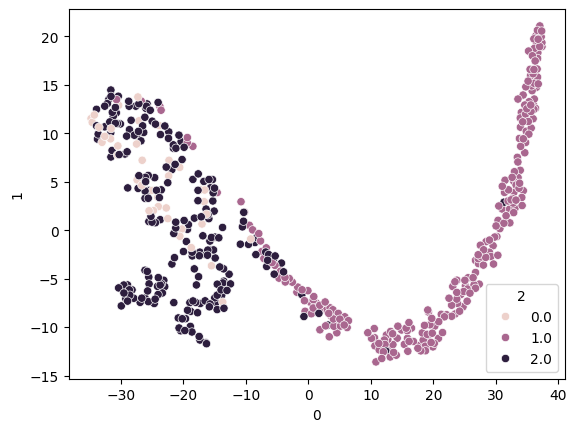

In [8]:
from sklearn.manifold import TSNE
import pandas as pd
tsne = TSNE()
Xi,yi = next(iter(trainloader))
Xi,yi = Xi.to(device),yi.to(device)

Xi_tsne = tsne.fit_transform(model.get_latent_space(Xi).detach().cpu())
df = pd.DataFrame(torch.hstack([torch.from_numpy(Xi_tsne),yi.detach().cpu().argmax(dim=1,keepdim=True)]))
sns.scatterplot(data=df,x=0,y=1,hue=2)

<Axes: xlabel='0', ylabel='1'>

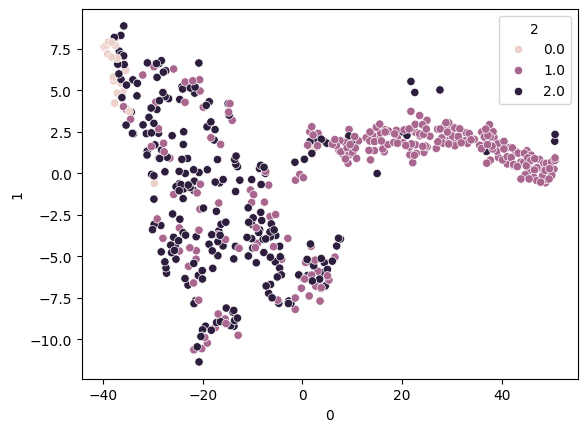

In [9]:
from sklearn.manifold import TSNE
import pandas as pd
tsne = TSNE()
Xi,yi = next(iter(testloader))
Xi,yi = Xi.to(device),yi.to(device)

Xi_tsne = tsne.fit_transform(model.get_latent_space(Xi).detach().cpu())
df = pd.DataFrame(torch.hstack([torch.from_numpy(Xi_tsne),yi.detach().cpu().argmax(dim=1,keepdim=True)]))
sns.scatterplot(data=df,x=0,y=1,hue=2)

<Axes: xlabel='0', ylabel='1'>

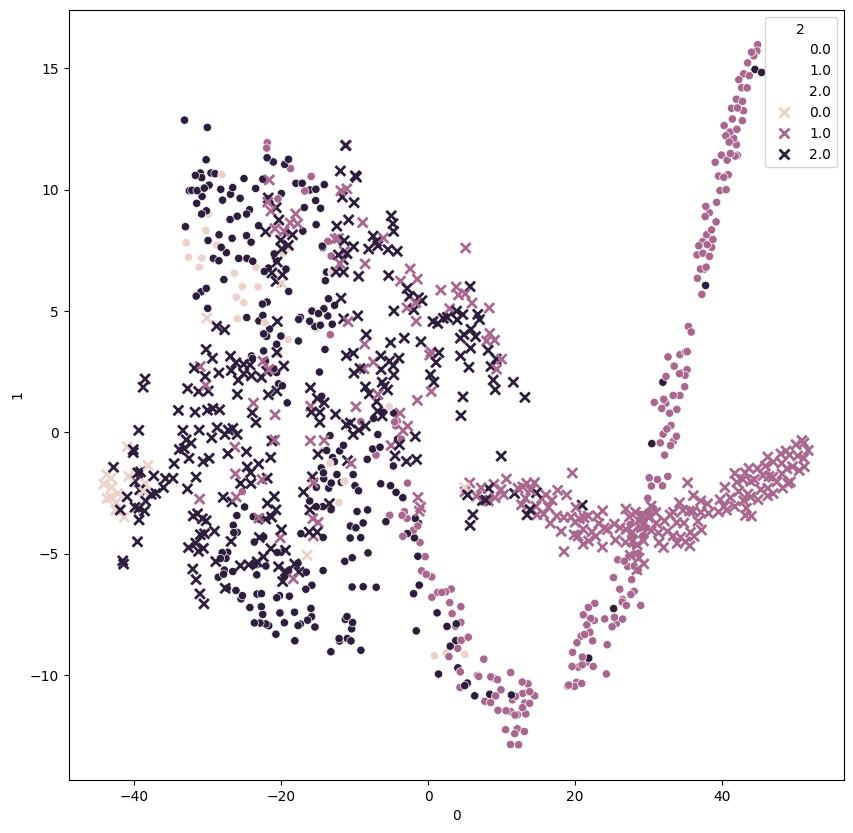

In [10]:
from sklearn.manifold import TSNE
import pandas as pd
tsne = TSNE()
Xi,yi = next(iter(trainloader))
Xi,yi = Xi.to(device),yi.to(device)
Xi_tsne = tsne.fit_transform(model.get_latent_space(Xi).detach().cpu())
df = pd.DataFrame(torch.hstack([torch.from_numpy(Xi_tsne),yi.detach().cpu().argmax(dim=1,keepdim=True)]))

plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x=0,y=1,hue=2,facecolors='none',marker='o')

Xi,yi = next(iter(testloader))
Xi,yi = Xi.to(device),yi.to(device)
Xi_tsne = tsne.fit_transform(model.get_latent_space(Xi).detach().cpu())
df = pd.DataFrame(torch.hstack([torch.from_numpy(Xi_tsne),yi.detach().cpu().argmax(dim=1,keepdim=True)]))
sns.scatterplot(data=df,x=0,y=1,hue=2,marker='x',s=50,linewidths=2)

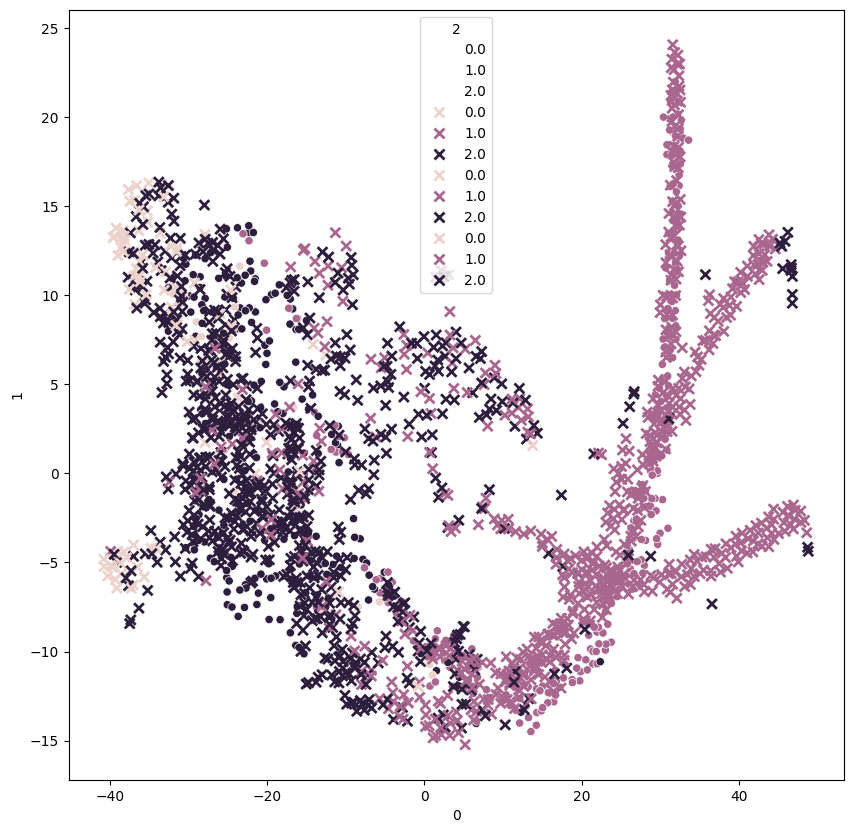

In [14]:
from sklearn.manifold import TSNE
import pandas as pd

tsne = TSNE()
Xi,yi = next(iter(trainloader))
Xi,yi = Xi.to(device),yi.to(device)
Xi_tsne = tsne.fit_transform(model.get_latent_space(Xi).detach().cpu())
df = pd.DataFrame(torch.hstack([torch.from_numpy(Xi_tsne),yi.detach().cpu().argmax(dim=1,keepdim=True)]))

plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x=0,y=1,hue=2,facecolors='none',marker='o')

for test_id in ekyn_ids[-3:]:
    testdataset  = ConcatDataset([EEGDataset(id=id,condition=condition) for id in [test_id] for condition in conditions])
    testloader = DataLoader(testdataset, batch_size=512, shuffle=True)

    Xi,yi = next(iter(testloader))
    Xi,yi = Xi.to(device),yi.to(device)
    
    tsne = TSNE()

    Xi_tsne = tsne.fit_transform(model.get_latent_space(Xi).detach().cpu())
    df = pd.DataFrame(torch.hstack([torch.from_numpy(Xi_tsne),yi.detach().cpu().argmax(dim=1,keepdim=True)]))
    sns.scatterplot(data=df,x=0,y=1,hue=2,marker='x',s=50,linewidths=2)

/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1096
           1       0.94      0.88      0.91      8006
           2       0.80      0.95      0.86      8178

    accuracy                           0.86     17280
   macro avg       0.58      0.61      0.59     17280
weighted avg       0.81      0.86      0.83     17280

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       616
           1       0.92      0.67      0.77      8051
           2       0.71      0.95      0.81      8613

    accuracy                           0.78     17280
   macro avg       0.55      0.54      0.53     17280
weighted avg       0.79      0.78      0.77     17280



/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


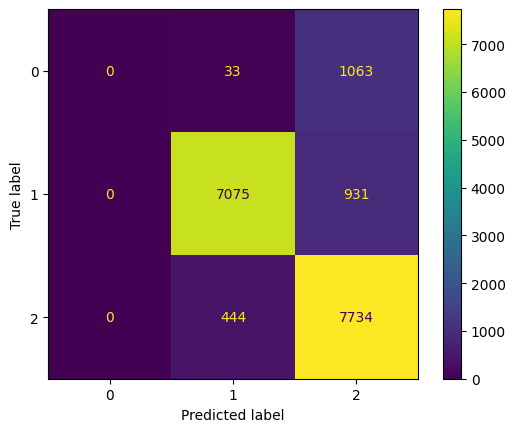

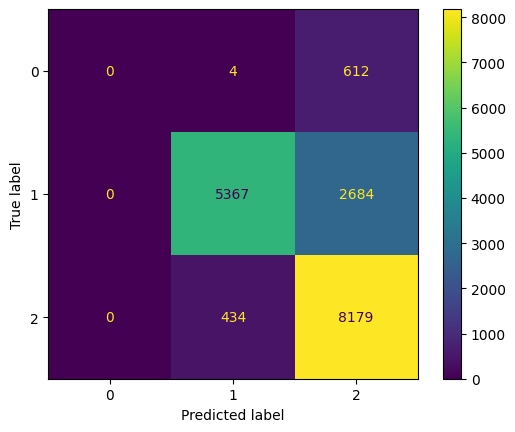

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).detach().cpu(),yi.argmax(dim=1).detach().cpu()]).T for Xi,yi in trainloader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)


y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).detach().cpu(),yi.argmax(dim=1).detach().cpu()]).T for Xi,yi in testloader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)